# Settings, Directory Specs, and Imports

In [1]:
# 0 = no streamlit
# 1 = test user inputs
# 2 = run in streamlit
streamlit_status = 0
#file_name_pickle_read = 'model_2020_06_06_1105.pickle'
do_plots = 1

dir_read = '/Users/rachellehorwitz/Documents/ViTalErt/data/filtered05/'
#dir_read = '/Users/rachellehorwitz/Documents/VTAlert/over18_eicu/'

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, confusion_matrix, plot_confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split, ShuffleSplit, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import streamlit as st
import pickle
from datetime import datetime
import pyprojroot


matplotlib.rcParams.update({'font.size': 22})

In [2]:
## LightGBM - same tool. Microsoft Research built their own version of XGradientBoost. 
## XGradientBoost
## If you look at kaggle challenges, the types of modles that get the highest accuracy
# on lab-like conditions where you have a fixed dataset, the types of models that win are gradient
# boosting (XGBoost) are NNs. People use XGBoost. Mention that it would be a route to go down
# but don't use it because it requires a particular data format
# Look at logistic regression equation. Look at coefficients I'm estimating. Use statsmodels
#### scikit learn implementation of p-values from the coefficients
#### In the end, I want to convince someone that an intervention is necessary
#### Value-add of ML is that a doctor could have a simple hypothesis, like "this is age-dependent"
#### I could throw subset of data in and I wouldn't get stat significance
#### Tie it back to statistical significance

# Function Definitions

In [3]:
def now_to_str():
    now = str(datetime.now())
    return now[0:4] + '_' + now[5:7] + '_' + now[8:10] + '_' + now[11:13] + now[14:16]

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     """
#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.

#     Parameters
#     ----------
#     estimator : object type that implements the "fit" and "predict" methods
#         An object of that type which is cloned for each validation.

#     title : string
#         Title for the chart.

#     X : array-like, shape (n_samples, n_features)
#         Training vector, where n_samples is the number of samples and
#         n_features is the number of features.

#     y : array-like, shape (n_samples) or (n_samples, n_features), optional
#         Target relative to X for classification or regression;
#         None for unsupervised learning.

#     axes : array of 3 axes, optional (default=None)
#         Axes to use for plotting the curves.

#     ylim : tuple, shape (ymin, ymax), optional
#         Defines minimum and maximum yvalues plotted.

#     cv : int, cross-validation generator or an iterable, optional
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:

#           - None, to use the default 5-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, optional (default=None)
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like, shape (n_ticks,), dtype float or int
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the dtype is float, it is regarded as a
#         fraction of the maximum size of the training set (that is determined
#         by the selected validation method), i.e. it has to be within (0, 1].
#         Otherwise it is interpreted as absolute sizes of the training sets.
#         Note that for classification the number of samples usually have to
#         be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """
#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# #X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# #cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = GaussianNB()
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# plt.show()

In [5]:
# # https://towardsdatascience.com/feature-importance-and-forward-feature-selection-752638849962
# # Input : Dataframe df with m features, number of required features n
# # Output : Set of n features most useful for model performance
# from sklearn.linear_model import SGDClassifier

# def forward_feature_selection(x_train, x_cv, y_train, y_cv, n):
#     feature_set = []
#     for num_features in range(n):
#         metric_list = [] # Choose appropriate metric based on business problem
#         model = SGDClassifier() # You can choose any model you like, this technique is model agnostic
#         for feature in x_train.columns:
#             if feature not in feature_set:
#                 f_set = feature_set.copy()
#                 f_set.append(feature)
#                 model.fit(x_train[f_set], y_train)
#                 metric_list.append((evaluate_metric(model, x_cv[f_set], y_cv), feature))

#         metric_list.sort(key=lambda x : x[0], reverse = True) # In case metric follows "the more, the merrier"
#         feature_set.append(metric_list[0][1])
#     return feature_set

# feature_set = forward_feature_selection(X_train, X_val, y_train, y_val, 10)

# Defining X and y

In [6]:
Xy = pd.read_csv('/Users/rachellehorwitz/Documents/ViTalErt/notebooks/Xy_2020_06_09_0915.csv')
Xy = Xy.set_index('patientunitstayid')
y = Xy.pop('label')
X = Xy.copy()
X.columns
X = X.drop(columns=['patienthealthsystemstayid', 'unitstaytype_stepdown/other'])

In [7]:
# # Partition and train model
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=1)
# #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Breakpoint

In [8]:
if streamlit_status == 1:
    age = 30
    admissionweight = 50
if streamlit_status == 2:
    age = st.slider('Age', 19, 90)
    admissionweight = st.slider('Admission Weight (kg)', 40, 300)
if (streamlit_status == 1) | (streamlit_status == 2): 
    input_data = {'age': [age], 'admissionweight': [admissionweight]}
    X_test = pd.DataFrame(input_data, columns=['age', 'admissionweight'])

# Model and Predict

In [9]:
# THRESHOLD = 0.01
# y_pred = np.where(log_clf.predict_proba(x_train)[:,1] > THRESHOLD, 1, 0) # log_clf: classifier. 
# # [:,1]: picking out positive probabilities. where that's true, insert value of 1, otherwise 0

In [10]:
# Grid search
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)

In [11]:
# Tune hyperparameters
hyperparam_grid = {'penalty': ['l1', 'l2'], 'C': np.arange(0.5, 20, 0.5), 'fit_intercept': [True, False]}
logreg =  LogisticRegression(class_weight='balanced')
param = {'C':[0.00001, 0.0001, 0.001]}#0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1,2,3,3,4,5,10,20]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=10)
clf.fit(X_train_s,y_train)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_))

Best roc_auc: 0.6927, with best C: {'C': 0.0001}


In [12]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

0.6725544394256051
F1 score is: 0.012001627339300247
No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.713


<IPython.core.display.Javascript object>


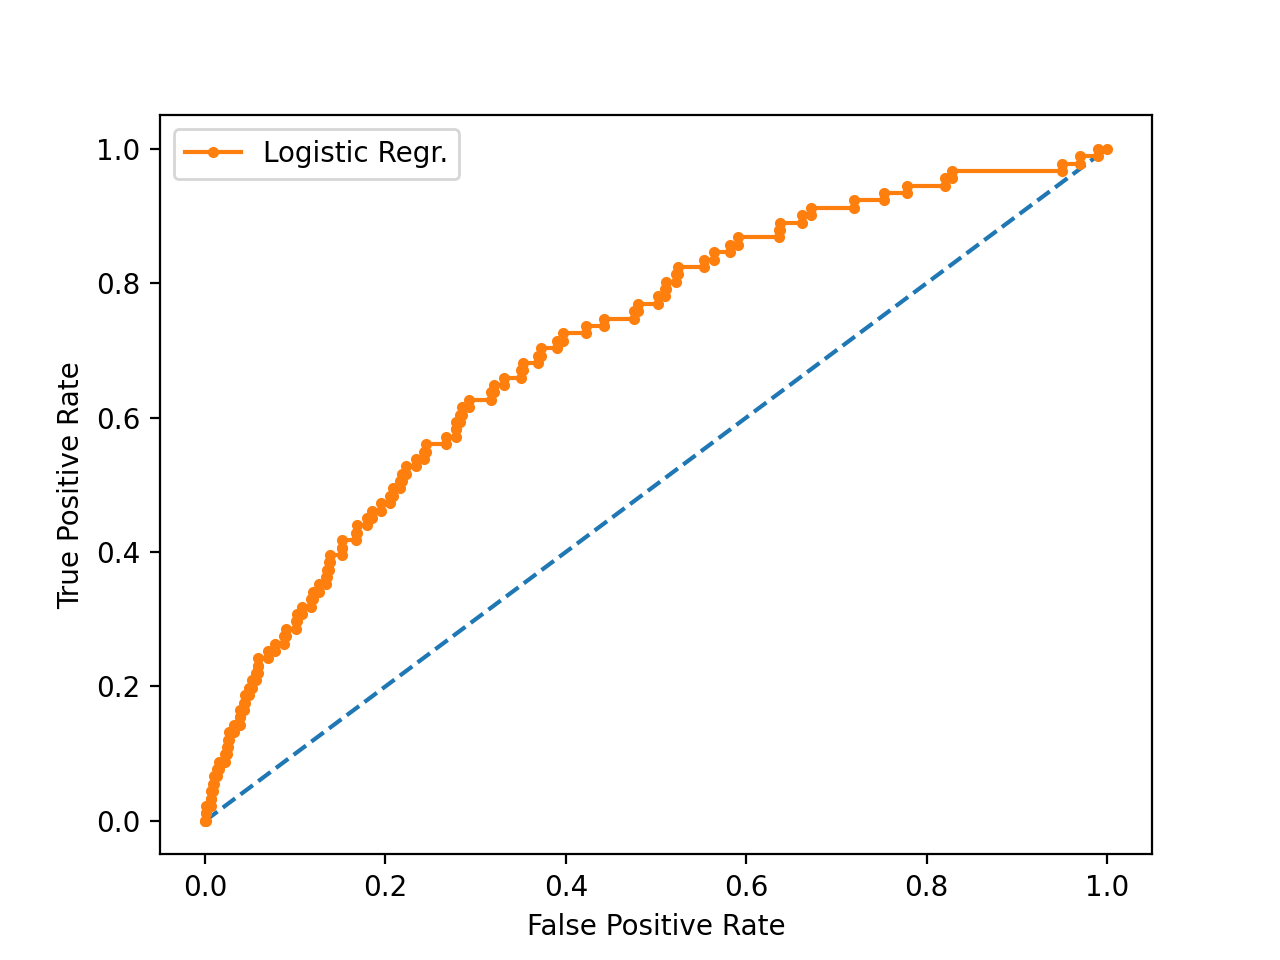

prob_sc:  min = 1.1288256712588315e-05
	    max = 0.9575598054192292


,feature,coef,abs_weight
0,age,0.112718,0.112718
1,admissionweight,0.197410,0.197410
2,admissionheight,-0.000679,0.000679
3,bmi,0.022008,0.022008
4,gender_Female,0.017563,0.017563


In [13]:
%matplotlib notebook
# # Logistic Regression - basic form
# logisticRegr_sc = make_pipeline(StandardScaler(), LogisticRegression())
logisticRegr_sc = LogisticRegression(class_weight='balanced')
# logisticRegr_sc.fit(X_train, y_train)
# file_name_pickle = 'model_' + now_to_str() + '.pickle'
# pickle.dump(logisticRegr_sc, open(file_name_pickle, 'wb'))

# # if (streamlit_status == 1) | (streamlit_status == 2):
# #     logisticRegr_sc = pickle.load(open(file_name_pickle_read, 'rb'))

# yhat_logisticRegr_sc = logisticRegr_sc.predict(X_test)
# prob_logisticRegr_sc = logisticRegr_sc.predict_proba(X_test)[:,1]

logisticRegr_sc = LogisticRegression(class_weight='balanced')
logisticRegr_sc.fit(X_train_sc, y_train)

yhat_logisticRegr_sc = logisticRegr_sc.predict(X_test_sc)
prob_logisticRegr_sc = logisticRegr_sc.predict_proba(X_test_sc)[:,1]

#lprob_sc = logisticRegr_sc.predict_log_proba(X_test)[:,1]

scores_sc = logisticRegr_sc.score(X_test_sc, y_test)
print(scores_sc)
print('F1 score is: ' + str(f1_score(y_test, yhat_logisticRegr_sc)))

# # Print baseline accuracy
# N0_bl = patient[patient['label']==0].shape[0]
# N1_bl = patient[patient['label']==1].shape[0]
# print('{:d} patients in negative class'.format(N0_bl))
# print('{:d} patients in positive class'.format(N1_bl))
# print('If you predict 0 all the time, accuracy is {:.5f}%'.format(N0_bl/(N0_bl+N1_bl)))

# cm = confusion_matrix(list(y_test), yhat_logisticRegr_sc)
# plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test))
# plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test),  normalize='true')

# ROC curve (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
noskill_probs = [0 for _ in range(len(y_test))]
noskill_auc = roc_auc_score(y_test, noskill_probs)
logisticRegr_auc = roc_auc_score(y_test, prob_logisticRegr_sc)
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, prob_logisticRegr_sc)

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

print('prob_sc:  min = ' + str(np.min(prob_logisticRegr_sc)))
print('\t    max = ' + str(np.max(prob_logisticRegr_sc)))

# Get feature weights and put into dataframe
mydict = {'feature': X_train.columns, 'coef': list(logisticRegr_sc.coef_.reshape(-1,1).flatten())}
features_weights = pd.DataFrame(mydict)
features_weights = features_weights.assign(abs_weight=np.abs(features_weights['coef']))
features_weights.head()

In [ ]:
# # Feature selection using Recursive Feature Elimination (RFE)
# # https://towardsdatascience.com/a-look-into-feature-importance-in-logistic-regression-models-a4aa970f9b0f
# from sklearn.feature_selection import RFE
# predictors = X_train
# selector = RFE(logisticRegr_sc, n_features_to_select = 1) # n_features_to_select gives full ranking of features
# selector = selector.fit(predictors, y_train)

# order = selector.ranking_
# order

# Breakpoint

In [ ]:
# https://www.kaggle.com/sudhirnl7/logistic-regression-with-stratifiedkfold

kf = StratifiedKFold(n_splits=10,shuffle=True)
pred_test_full =0
cv_score =[]
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
#     xtr,xvl = X.loc[train_index],y.loc[test_index]
#     ytr,yvl = X.loc[train_index],y.loc[test_index]
    
    xtr,xvl = X.loc[train_index],y.loc[test_index]
    ytr,yvl = X[train_index],y[test_index]
    
    #model
    logisticRegr_sc.fit(xtr,ytr)
    score = roc_auc_score(yvl,logisticRegr_sc.predict(xvl))
    print('ROC AUC score:',score)
#     cv_score.append(score)    
#     pred_test = logisticRegr_sc.predict_proba(X_test)[:,1]
#     pred_test_full +=pred_test
#     i+=1

In [ ]:
train_index

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
# generate 2 class dataset
X2, y2 = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], flip_y=0, random_state=1)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# enumerate the splits and summarize the distributions
for train_ix, test_ix in kfold.split(X2, y2):
    # select rows
    train_X2, test_X2 = X2[train_ix], X2[test_ix]
    train_y2, test_y2 = y[train_ix], y[test_ix]
    # summarize train and test composition
    train_0, train_1 = len(train_y2[train_y==0]), len(train_y2[train_y==1])
    test_0, test_1 = len(test_y2[test_y==0]), len(test_y2[test_y==1])
    print('>Train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

In [ ]:
train_index

In [ ]:

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# # Plot learning curve
# plt.figure()
# #axes = axes[:,1]
# plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      train_sizes_abs="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1,
#                      color="g")
# plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
#              label="Training score")
# plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")
# plt.legend(loc="best")

In [ ]:
# Random Forest Classification - basic form
from sklearn.ensemble import RandomForestClassifier
rfc_vanilla = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
rfc_vanilla.fit(X_train, y_train)
rfc_vanilla_probs = rfc_vanilla.predict_proba(X_test)[:,1]
print('******************************')
print('Random Forest - vanilla')
print('AUC:' + str(roc_auc_score(y_test, rfc_vanilla_probs)))
print('Probability of VTE:  min = ' + str(np.min(rfc_vanilla_probs)))
print('\t    max = ' + str(np.max(rfc_vanilla_probs)))

In [ ]:
# Random Forest Classification - basic form
from sklearn.ensemble import RandomForestClassifier
rfc_vanilla = RandomForestClassifier(n_estimators=100, random_state=0, criterion='entropy', class_weight='balanced')
rfc_vanilla.fit(X_train, y_train)
rfc_vanilla_probs = rfc_vanilla.predict_proba(X_test)[:,1]
print('******************************')
print('Random Forest - Balanced class weights')
print('AUC:' + str(roc_auc_score(y_test, rfc_vanilla_probs)))
print('Probability of VTE:  min = ' + str(np.min(rfc_vanilla_probs)))
print('\t    max = ' + str(np.max(rfc_vanilla_probs)))

In [ ]:
rfc_vanilla_probs

In [ ]:
logisticRegr_sc = make_pipeline(StandardScaler(), LogisticRegression())
logisticRegr_sc.fit(X_train, y_train)
file_name_pickle = 'model_' + now_to_str() + '.pickle'
pickle.dump(logisticRegr_sc, open(file_name_pickle, 'wb'))

# if (streamlit_status == 1) | (streamlit_status == 2):
#     logisticRegr_sc = pickle.load(open(file_name_pickle_read, 'rb'))

yhat_logisticRegr_sc = logisticRegr_sc.predict(X_test)
prob_logisticRegr_sc = logisticRegr_sc.predict_proba(X_test)[:,1]
#lprob_sc = logisticRegr_sc.predict_log_proba(X_test)[:,1]

scores_sc = logisticRegr_sc.score(X_test, y_test)
print(scores_sc)
print('F1 score is: ' + str(f1_score(y_test, yhat_logisticRegr_sc)))

# # Print baseline accuracy
# N0_bl = patient[patient['label']==0].shape[0]
# N1_bl = patient[patient['label']==1].shape[0]
# print('{:d} patients in negative class'.format(N0_bl))
# print('{:d} patients in positive class'.format(N1_bl))
# print('If you predict 0 all the time, accuracy is {:.5f}%'.format(N0_bl/(N0_bl+N1_bl)))

# cm = confusion_matrix(list(y_test), yhat_logisticRegr_sc)
# plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test))
# plot_confusion_matrix(logisticRegr_sc, X_test, list(y_test),  normalize='true')

# ROC curve (https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
noskill_probs = [0 for _ in range(len(y_test))]
noskill_auc = roc_auc_score(y_test, noskill_probs)
logisticRegr_auc = roc_auc_score(y_test, prob_logisticRegr_sc)
print('No Skill: ROC AUC=%.3f' % (noskill_auc))
print('Logistic: ROC AUC=%.3f' % (logisticRegr_auc))
ns_fpr, ns_tpr, _ = roc_curve(y_test, noskill_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, prob_logisticRegr_sc)

plt.figure()
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic Regr.')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()



# Breakpoint